# Sentiment Analysis - Spanish Movie Reviews
**By Zach Friedman**, zacheryfriedman@my.unt.edu

In [17]:
import pandas as pd
import nltk
import numpy as np

# NLTK VADER imports
from nltk.tokenize import WordPunctTokenizer, sent_tokenize
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
# Naive Bayes imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.linear_model import LogisticRegression
import regex as re
'''
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
'''

"\nnltk.download('punkt')\nnltk.download('stopwords')\nnltk.download('sentiwordnet')\nnltk.download('wordnet')\nnltk.download('omw-1.4')\nnltk.download('vader_lexicon')\n"

## Preliminary Model: VADER Sentiment Analysis Tool
> https://github.com/cjhutto/vaderSentiment

In [54]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/NLP/IMDB Dataset SPANISH.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
hyperlinks = r'https?://[A-Za-z0-9./]+'
emails = r'\S+@\S+'
sentence = r'\.(?=[A-Z])'

def replace_pattern(pattern):
    return ''

def insert_space(pattern):
    return pattern.group() + ' '

# Clean the Spanish reviews
df['review_es'] = df['review_es'].apply(lambda x: re.sub(hyperlinks, replace_pattern, x))
df['review_es'] = df['review_es'].apply(lambda x: re.sub(emails, replace_pattern, x))
df['review_es'] = df['review_es'].apply(lambda x: re.sub(sentence, insert_space, x))

In [56]:
def analyze(doc):
    sia = SentimentIntensityAnalyzer()
    #doc = " ".join(doc)
    #sentiment = sia.polarity_scores(doc)
    return sia.polarity_scores(doc)

def sentence_tokenizer(doc):
    sentences = sent_tokenize(doc)
    #lemmatizer = WordNetLemmatizer()
    
    sentences = [[word.lower() for word in sent.split() if word not in stopwords.words('spanish')] for sent in sentences]
    
    return [" ".join(sent) for sent in sentences]

In [57]:
df['review_es'] = df['review_es'].apply(sentence_tokenizer) # Apply sentence tokenization to each Spanish review in the dataframe

KeyboardInterrupt: ignored

In [ ]:
labels = [] # A list to hold the predicted labels for each review

for i in range(len(df)): # For each review in the dataframe...
    review_sentiment = [] # A list to hold the sentiments of each sentence in a review

    for sent in df['review_es'].iloc()[i]: # For each sentence in a review...

        analysis = analyze(sent) # Apply the sentiment intensity analyzer to each sentence

        subset = ['neg', 'pos'] # We only care about the negative and positive scores, since the dataset does not include neutral labels
        subset_dict = {key: value for key, value in analysis.items() if key in subset} # Create a subset dictionary with 'neg' and 'pos' key-value pairs

        sentiment = max(subset_dict, key=subset_dict.get) # Get the maximum of the 'neg' and 'pos' scores

        review_sentiment.append(sentiment) # Append the sentiment for the current sentence to the list of sentiments

    sentiment_counts = Counter(review_sentiment) # Count the number of 'neg' and 'pos' in the list of sentiments

    # Find the most common sentiment in the list of sentiments for a review and append the appropriate label to the list of prediction labels
    if sentiment_counts.most_common(1)[0][0] == 'neg':
        labels.append('negativo')
    else:
        labels.append('positivo')

predictions = pd.DataFrame(data=labels, columns=["prediction"])

predictions

In [38]:
df.head()

,Unnamed: 0,review_en,review_es,sentiment,sentimiento
0,0,One of the other reviewers has mentioned that ...,[uno críticos mencionado después ver solo 1 oz...,positive,positivo
1,1,A wonderful little production. The filming tec...,"[una pequeña pequeña producción., la técnica f...",positive,positivo
2,2,I thought this was a wonderful way to spend ti...,[pensé manera maravillosa pasar tiempo fin sem...,positive,positivo
3,3,Basically there's a family where a little boy ...,"[básicamente, familia niño pequeño (jake) pien...",negative,negativo
4,4,"Petter Mattei's ""Love in the Time of Money"" is...","[el ""amor tiempo"" petter mattei película visua...",positive,positivo


In [36]:
predictions.to_csv("spanish_predictions_v2.csv")

In [52]:
merged = pd.merge(df['sentimiento'], predictions['prediction'], left_index=True, right_index=True)

boolean_mask = merged.iloc[:,0] == merged.iloc[:,1]

vader_accuracy = boolean_mask.mean()

print(f"VADER accuracy: {vader_accuracy}")

VADER accuracy: 0.0


In [27]:
fresh_df = pd.read_csv('/content/drive/MyDrive/NLP/IMDB Dataset SPANISH.csv')

fresh_df = fresh_df.drop(['Unnamed: 0'], 1)
fresh_df = fresh_df.drop(['review_en'], 1)
fresh_df = fresh_df.drop(['sentiment'], 1)

<ipython-input-27-31536d3d884d>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  fresh_df = fresh_df.drop(['Unnamed: 0'], 1)
<ipython-input-27-31536d3d884d>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  fresh_df = fresh_df.drop(['review_en'], 1)
<ipython-input-27-31536d3d884d>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  fresh_df = fresh_df.drop(['sentiment'], 1)


In [31]:
fresh_df.head()

,review_es,sentimiento
0,Uno de los otros críticos ha mencionado que de...,positivo
1,Una pequeña pequeña producción.La técnica de f...,positivo
2,Pensé que esta era una manera maravillosa de p...,positivo
3,"Básicamente, hay una familia donde un niño peq...",negativo
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


In [35]:
fresh_df.to_csv("spanish_sanitized_v2.csv")

In [28]:
X = fresh_df.iloc[:, :-1]
y = fresh_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80/20 split

X_train = X_train['review_es'].tolist() # Convert Spanish reviews in X_train to a list of strings
X_test = X_test['review_es'].tolist() # Convert reviews in X_test to a list of strings

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

## Logistic Regression

In [29]:
lr = LogisticRegression(solver="newton-cg")

lr.fit(X_train, y_train)

yhat3 = lr.predict(X_test)

lr_accuracy = accuracy_score(y_test, yhat3)

In [34]:
print(f"Logistic Regression accuracy: {lr_accuracy}")

Logistic Regression accuracy: 0.8871


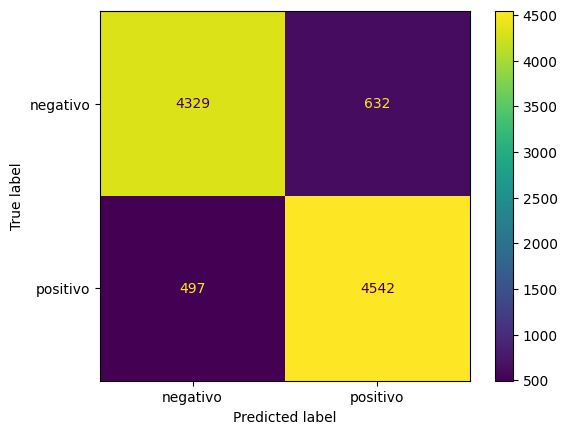

In [32]:
cm3 = confusion_matrix(y_test, yhat3)

cm3_display = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=['negativo', 'positivo'])

cm3_display.plot()

In [33]:
print(classification_report(y_test, yhat3))

              precision    recall  f1-score   support

    negativo       0.90      0.87      0.88      4961
    positivo       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [48]:
import pickle
filename = 'spanish_model.sav'
pickle.dump(lr, open('spanish_model.pkl', 'wb'))

In [50]:
pickle.dump(vectorizer, open('spanish_vectorizer.pkl', 'wb'))

In [43]:
from wordcloud import WordCloud

text = ' '.join(df['review_es'].astype(str)) # Join the text of every English review in the dataset into one long sentence
text = text.split(" ") # Split the long string of words into individual words

text = [word.lower() for word in text if word.lower() not in stopwords.words('spanish')] # Remove stopwords and lowercase

wordcloud_dict = Counter(text) # Create a counter for word frequencies
wordcloud = WordCloud(width=800, height=800, background_color='white', colormap='plasma', stopwords=stopwords.words('english')).generate_from_frequencies(wordcloud_dict)

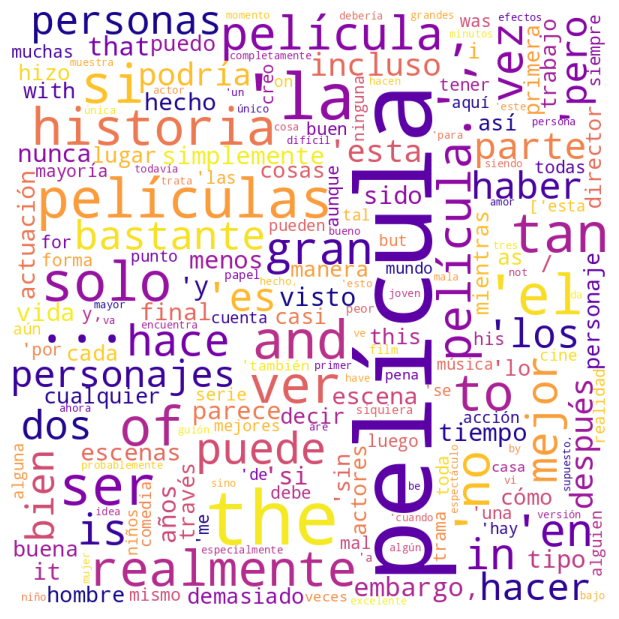

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()